In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib.dates as mdates

import random
import multiprocessing
from itertools import islice

In [2]:
from gluonts.evaluation import make_evaluation_predictions, Evaluator
from gluonts.dataset.repository.datasets import get_dataset
from pytorch_lightning.loggers import WandbLogger

from estimator import LagGPTEstimator

Setting ds_accelerator to cuda (auto detect)


In [3]:
class CombinedDatasetIterator:
    def __init__(self, datasets, seed, weights):
        self._datasets = [iter(el) for el in datasets]
        self._weights = weights
        self._rng = random.Random(seed)

    def __next__(self):
        (dataset,) = self._rng.choices(self._datasets, weights=self._weights, k=1)
        return next(dataset)

In [4]:
class CombinedDataset:
    def __init__(self, datasets, seed=None, weights=None):
        self._seed = seed
        self._datasets = datasets
        self._weights = weights
        n_datasets = len(datasets)
        if weights is None:
            self._weights = [1 / n_datasets] * n_datasets

    def __iter__(self):
        return CombinedDatasetIterator(self._datasets, self._seed, self._weights)
    
    def __len__(self):
        return sum([len(ds) for ds in self._datasets])

In [5]:
gluonts_ds = [
        get_dataset("airpassengers").train,
        get_dataset("australian_electricity_demand").train,
        get_dataset("car_parts_without_missing").train,
        get_dataset("cif_2016").train,
        get_dataset("covid_deaths").train,
        get_dataset("electricity").train,
        get_dataset("electricity_weekly").train,
        get_dataset("exchange_rate").train,
        get_dataset("fred_md").train,
        get_dataset("hospital").train,
        get_dataset("kaggle_web_traffic_weekly").train,
        get_dataset("kdd_cup_2018_without_missing").train,
        get_dataset("london_smart_meters_without_missing").train,
        get_dataset("nn5_daily_with_missing").train,
        get_dataset("nn5_weekly").train,
        get_dataset("pedestrian_counts").train,
        get_dataset("rideshare_without_missing").train,
        get_dataset("saugeenday").train,
        get_dataset("solar-energy").train,
        get_dataset("solar_10_minutes").train,
        get_dataset("solar_weekly").train,
        get_dataset("taxi_30min").train,
        get_dataset("temperature_rain_without_missing").train,
        get_dataset("tourism_monthly").train,
        get_dataset("uber_tlc_daily").train,
        get_dataset("uber_tlc_hourly").train,
        get_dataset("vehicle_trips_without_missing").train,
        get_dataset("weather").train,
        get_dataset("wiki-rolling_nips").train,
        get_dataset("m4_daily").train,
        get_dataset("m4_hourly").train,
        get_dataset("m4_monthly").train,
        get_dataset("m4_quarterly").train,
        get_dataset("m4_yearly").train,
        get_dataset("wind_farms_without_missing").train,
]
dataset = CombinedDataset(gluonts_ds, weights=[sum([len(x["target"]) for x in d]) for d in gluonts_ds])

In [7]:
val_dataset = get_dataset("m4_weekly").test

In [9]:
meta = get_dataset("m4_weekly").metadata

In [10]:
meta

MetaData(freq='H', target=None, feat_static_cat=[CategoricalFeatureInfo(name='feat_static_cat_0', cardinality='862')], feat_static_real=[], feat_dynamic_real=[], feat_dynamic_cat=[], prediction_length=24)

In [60]:
estimator = LagGPTEstimator(
    prediction_length=meta.prediction_length,
    context_length=1024, # block_size: int = 2048 
    batch_size=32, # 4
    n_layer=8,
    n_head=4,
    n_embd=64, # 4096
    scaling="std",
    num_batches_per_epoch=100,
    trainer_kwargs=dict(max_epochs=100, accelerator="gpu", precision="bf16-mixed", logger=WandbLogger()),
)

In [61]:
predictor = estimator.train(
    training_data=dataset, 
    validation_data=val_dataset,
    shuffle_buffer_length=1000
)

Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type        | Params
--------------------------------------
0 | model | LagGPTModel | 531 K 
--------------------------------------
531 K     Trainable params
0         Non-trainable params
531 K     Total params
2.125     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 0, global step 100: 'val_loss' reached -1.50450 (best -1.50450), saving model to './lightning_logs/hnmpoejj/checkpoints/epoch=0-step=100-v1.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 1, global step 200: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 2, global step 300: 'val_loss' reached -2.10139 (best -2.10139), saving model to './lightning_logs/hnmpoejj/checkpoints/epoch=2-step=300.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 3, global step 400: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 4, global step 500: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 5, global step 600: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 6, global step 700: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 7, global step 800: 'val_loss' reached -2.44375 (best -2.44375), saving model to './lightning_logs/hnmpoejj/checkpoints/epoch=7-step=800.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 8, global step 900: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 9, global step 1000: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 10, global step 1100: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 11, global step 1200: 'val_loss' reached -2.57781 (best -2.57781), saving model to './lightning_logs/hnmpoejj/checkpoints/epoch=11-step=1200.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 12, global step 1300: 'val_loss' reached -2.62684 (best -2.62684), saving model to './lightning_logs/hnmpoejj/checkpoints/epoch=12-step=1300.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 13, global step 1400: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 14, global step 1500: 'val_loss' reached -2.68581 (best -2.68581), saving model to './lightning_logs/hnmpoejj/checkpoints/epoch=14-step=1500.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 15, global step 1600: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 16, global step 1700: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 17, global step 1800: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 18, global step 1900: 'val_loss' reached -2.82621 (best -2.82621), saving model to './lightning_logs/hnmpoejj/checkpoints/epoch=18-step=1900.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 19, global step 2000: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 20, global step 2100: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 21, global step 2200: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 22, global step 2300: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 23, global step 2400: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 24, global step 2500: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 25, global step 2600: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 26, global step 2700: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 27, global step 2800: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 28, global step 2900: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 29, global step 3000: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 30, global step 3100: 'val_loss' reached -2.86633 (best -2.86633), saving model to './lightning_logs/hnmpoejj/checkpoints/epoch=30-step=3100.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 31, global step 3200: 'val_loss' reached -2.90842 (best -2.90842), saving model to './lightning_logs/hnmpoejj/checkpoints/epoch=31-step=3200.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 32, global step 3300: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 33, global step 3400: 'val_loss' reached -2.99465 (best -2.99465), saving model to './lightning_logs/hnmpoejj/checkpoints/epoch=33-step=3400.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 34, global step 3500: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 35, global step 3600: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 36, global step 3700: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 37, global step 3800: 'val_loss' reached -3.01337 (best -3.01337), saving model to './lightning_logs/hnmpoejj/checkpoints/epoch=37-step=3800.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 38, global step 3900: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 39, global step 4000: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 40, global step 4100: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 41, global step 4200: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 42, global step 4300: 'val_loss' reached -3.01723 (best -3.01723), saving model to './lightning_logs/hnmpoejj/checkpoints/epoch=42-step=4300.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 43, global step 4400: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 44, global step 4500: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 45, global step 4600: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 46, global step 4700: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 47, global step 4800: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 48, global step 4900: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 49, global step 5000: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 50, global step 5100: 'val_loss' reached -3.06281 (best -3.06281), saving model to './lightning_logs/hnmpoejj/checkpoints/epoch=50-step=5100.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 51, global step 5200: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 52, global step 5300: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 53, global step 5400: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 54, global step 5500: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 55, global step 5600: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 56, global step 5700: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 57, global step 5800: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 58, global step 5900: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 59, global step 6000: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 60, global step 6100: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 61, global step 6200: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 62, global step 6300: 'val_loss' reached -3.09130 (best -3.09130), saving model to './lightning_logs/hnmpoejj/checkpoints/epoch=62-step=6300.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 63, global step 6400: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 64, global step 6500: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 65, global step 6600: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 66, global step 6700: 'val_loss' reached -3.09168 (best -3.09168), saving model to './lightning_logs/hnmpoejj/checkpoints/epoch=66-step=6700.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 67, global step 6800: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 68, global step 6900: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 69, global step 7000: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 70, global step 7100: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 71, global step 7200: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 72, global step 7300: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 73, global step 7400: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 74, global step 7500: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 75, global step 7600: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 76, global step 7700: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 77, global step 7800: 'val_loss' reached -3.11901 (best -3.11901), saving model to './lightning_logs/hnmpoejj/checkpoints/epoch=77-step=7800.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 78, global step 7900: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 79, global step 8000: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 80, global step 8100: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 81, global step 8200: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 82, global step 8300: 'val_loss' reached -3.12294 (best -3.12294), saving model to './lightning_logs/hnmpoejj/checkpoints/epoch=82-step=8300.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 83, global step 8400: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 84, global step 8500: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 85, global step 8600: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 86, global step 8700: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 87, global step 8800: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 88, global step 8900: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 89, global step 9000: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 90, global step 9100: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 91, global step 9200: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 92, global step 9300: 'val_loss' reached -3.12456 (best -3.12456), saving model to './lightning_logs/hnmpoejj/checkpoints/epoch=92-step=9300.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 93, global step 9400: 'val_loss' reached -3.13742 (best -3.13742), saving model to './lightning_logs/hnmpoejj/checkpoints/epoch=93-step=9400.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 94, global step 9500: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 95, global step 9600: 'val_loss' reached -3.14545 (best -3.14545), saving model to './lightning_logs/hnmpoejj/checkpoints/epoch=95-step=9600.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 96, global step 9700: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 97, global step 9800: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 98, global step 9900: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 99, global step 10000: 'val_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=100` reached.


In [8]:
test_dataset = get_dataset("traffic").test

In [75]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_dataset, predictor=predictor
)

In [76]:
forecasts = list(forecast_it)

In [77]:
tss = list(ts_it)

In [79]:
# num_workers is limited to 10 if cpu has more cores
num_workers = min(multiprocessing.cpu_count(), 10)

evaluator = Evaluator(num_workers=num_workers)
agg_metrics, ts_metrics = evaluator(
    iter(tss), iter(forecasts), num_series=len(test_dataset)
)


Running evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 862/862 [00:00<00:00, 10119.91it/s]
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:422: RuntimeWarning: divide by zero encountered in scalar divide
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/.env/pytorch/lib/python3.10/site-packages/pandas/core/dtypes/astype.py:138: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)


In [80]:
agg_metrics

{'MSE': 0.0008340203316951793,
 'abs_error': 154.73986280150712,
 'abs_target_sum': 707.1015980988741,
 'abs_target_mean': 0.06310026754407229,
 'seasonal_error': 0.015217962292658005,
 'MASE': 0.891145713940381,
 'MAPE': 0.21024225202584315,
 'sMAPE': 0.19028662169073263,
 'MSIS': 9.05787356689422,
 'QuantileLoss[0.1]': 67.84689556823578,
 'Coverage[0.1]': 0.11056576833839014,
 'QuantileLoss[0.2]': 104.77342862589286,
 'Coverage[0.2]': 0.21488488309834017,
 'QuantileLoss[0.3]': 130.31362868160937,
 'Coverage[0.3]': 0.31268963055505977,
 'QuantileLoss[0.4]': 146.06636297227814,
 'Coverage[0.4]': 0.420578261645547,
 'QuantileLoss[0.5]': 154.73986281245016,
 'Coverage[0.5]': 0.5359628770301624,
 'QuantileLoss[0.6]': 155.26630032770336,
 'Coverage[0.6]': 0.6245761199357487,
 'QuantileLoss[0.7]': 147.9602861020714,
 'Coverage[0.7]': 0.7222916294842048,
 'QuantileLoss[0.8]': 130.14225341342387,
 'Coverage[0.8]': 0.8090308763162591,
 'QuantileLoss[0.9]': 96.17765893451869,
 'Coverage[0.9]': 

In [13]:
agg_metrics

{'MSE': 1275900.1749048259,
 'abs_error': 6154841.872314453,
 'abs_target_sum': 46388328.9987793,
 'abs_target_mean': 5383.975046283576,
 'seasonal_error': 220.28471316811846,
 'MASE': 9.176973992686692,
 'MAPE': 0.22037375716020388,
 'sMAPE': 0.1730620001071758,
 'MSIS': 114.98121231759113,
 'QuantileLoss[0.1]': 3623775.546736145,
 'Coverage[0.1]': 0.31162952646239556,
 'QuantileLoss[0.2]': 4811165.9578125,
 'Coverage[0.2]': 0.3658310120705664,
 'QuantileLoss[0.3]': 5534423.283587647,
 'Coverage[0.3]': 0.40041782729805014,
 'QuantileLoss[0.4]': 5965409.865649414,
 'Coverage[0.4]': 0.42815691736304545,
 'QuantileLoss[0.5]': 6154841.878082275,
 'Coverage[0.5]': 0.4578690807799443,
 'QuantileLoss[0.6]': 6141123.800476074,
 'Coverage[0.6]': 0.49106313834726095,
 'QuantileLoss[0.7]': 5860293.170120239,
 'Coverage[0.7]': 0.527623026926648,
 'QuantileLoss[0.8]': 5237538.292456055,
 'Coverage[0.8]': 0.5766016713091922,
 'QuantileLoss[0.9]': 4077951.144604492,
 'Coverage[0.9]': 0.6525069637883

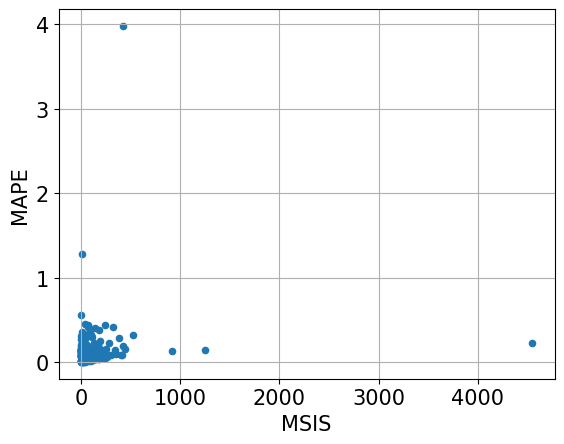

In [74]:
ts_metrics.plot(x="MSIS", y="MAPE", kind="scatter")
plt.grid(which="both")
plt.show()

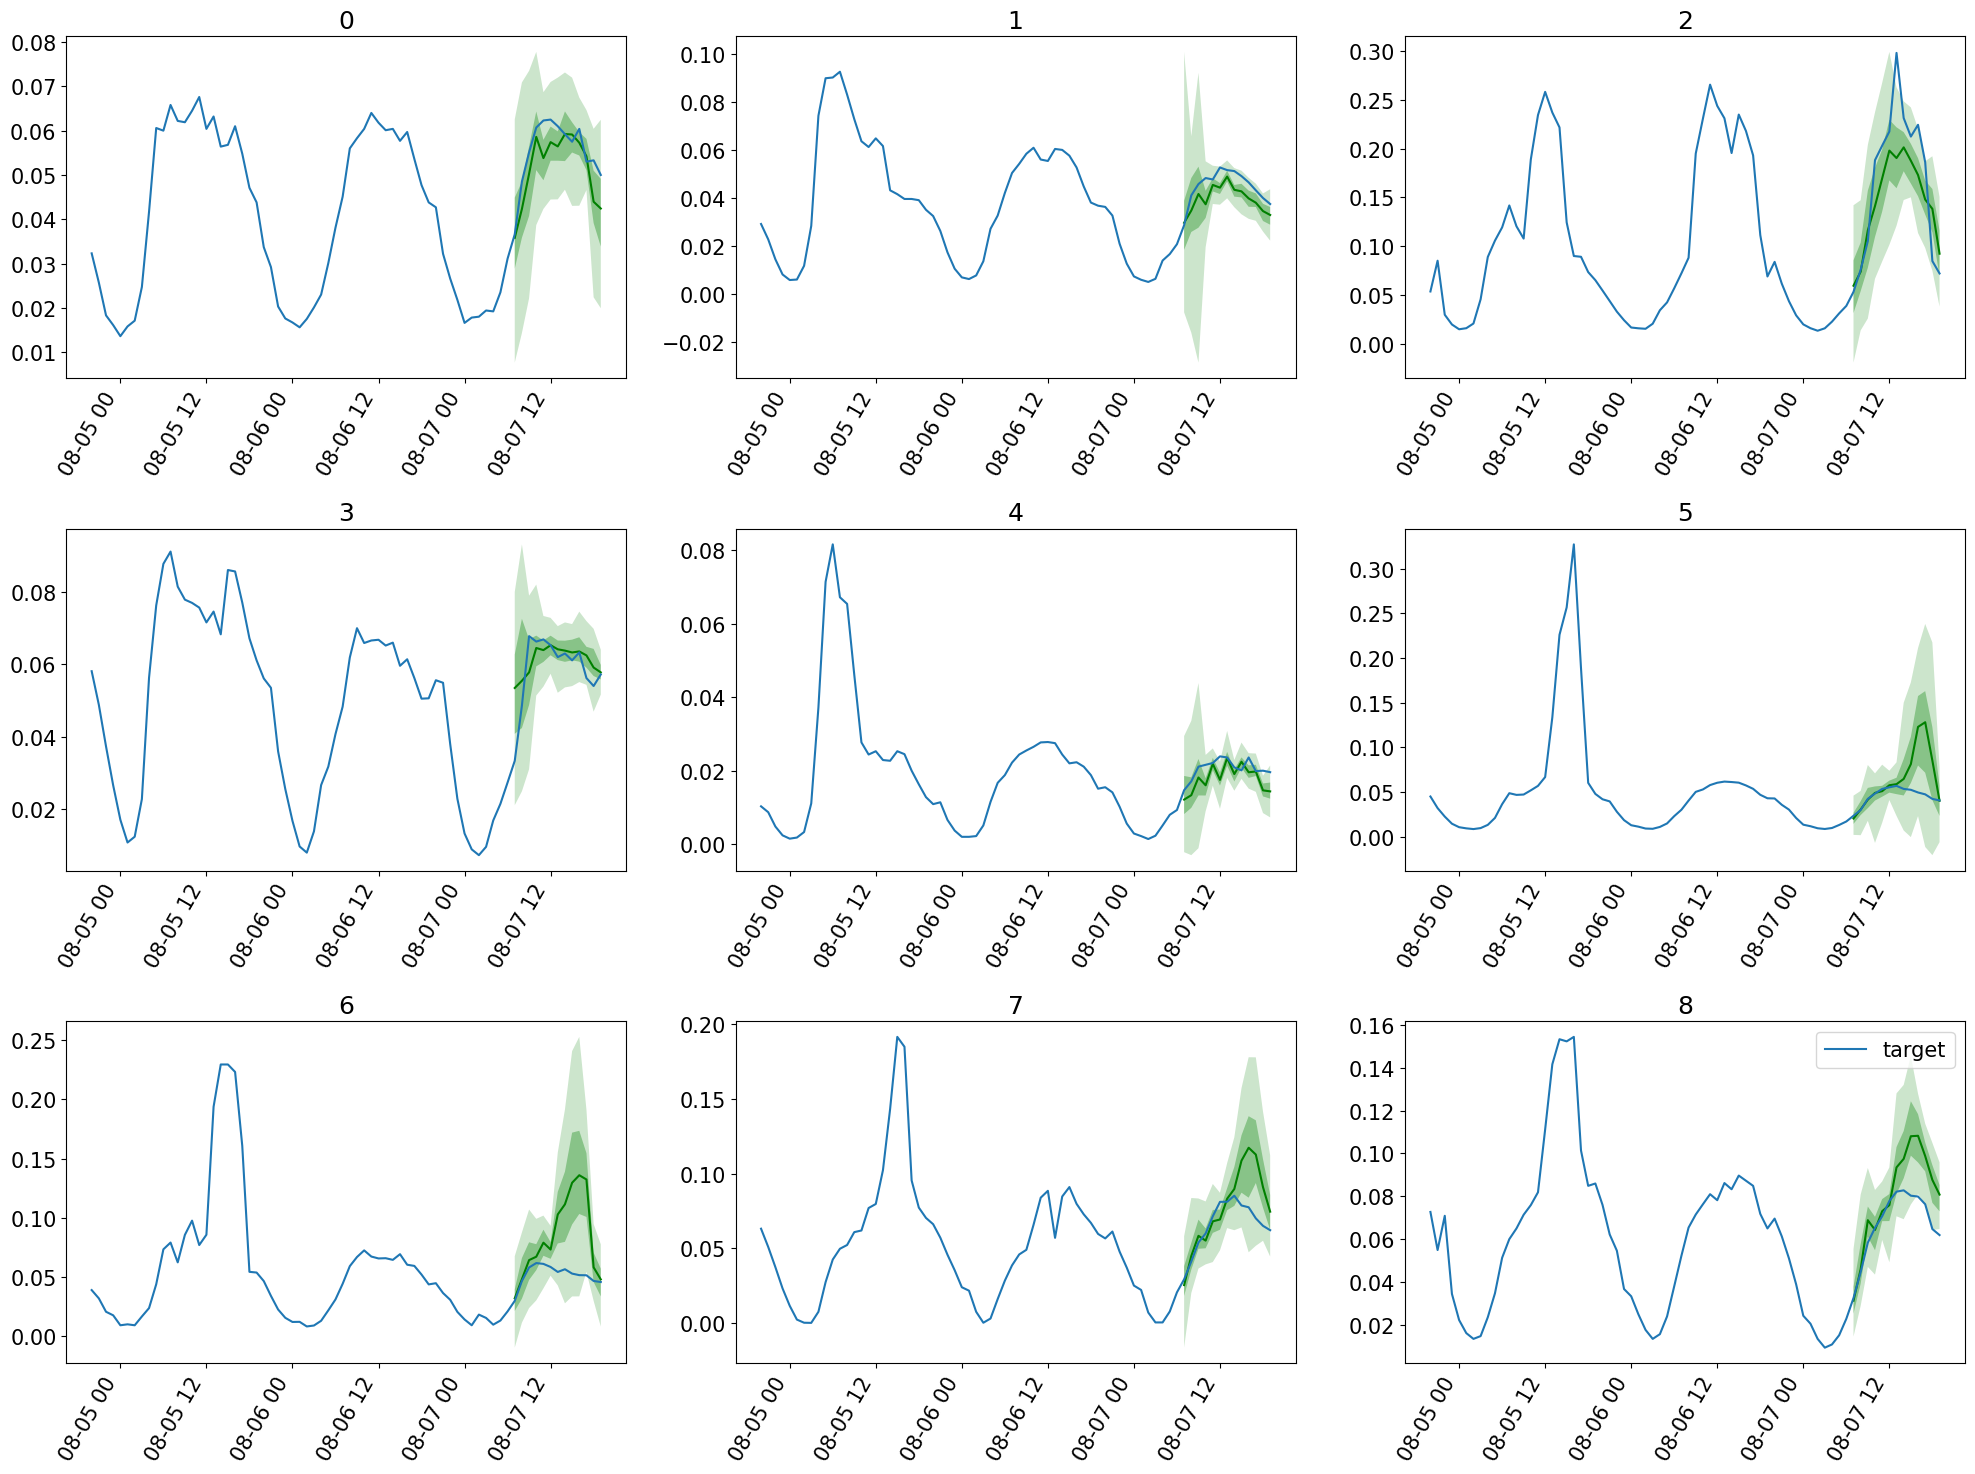

In [81]:
plt.figure(figsize=(20, 15))
plt.rcParams.update({'font.size': 15})

for idx, (forecast, ts) in islice(enumerate(zip(forecasts, tss)), 9):
    ax = plt.subplot(3, 3, idx+1)
    forecast.plot(color='g')
    ts[-3 * 24:][0].plot(label="target")
    plt.xticks(rotation=60)
    ax.set_title(forecast.item_id)

plt.gcf().tight_layout()
plt.legend()
plt.show()

In [10]:
# beam
agg_metrics

{'MSE': 2353700.5849478617,
 'abs_error': 10347671.897188187,
 'abs_target_sum': 128632956.0,
 'abs_target_mean': 2385.272140631954,
 'seasonal_error': 189.49338196116761,
 'MASE': 0.8922449918745382,
 'MAPE': 0.11220455807131616,
 'sMAPE': 0.1165269710200355,
 'MSIS': 12.069460309886567,
 'QuantileLoss[0.1]': 4623474.5003027115,
 'Coverage[0.1]': 0.15873015873015875,
 'QuantileLoss[0.2]': 6818143.679625946,
 'Coverage[0.2]': 0.23221703011422637,
 'QuantileLoss[0.3]': 8406636.595204707,
 'Coverage[0.3]': 0.29175938288087816,
 'QuantileLoss[0.4]': 9575201.4348929,
 'Coverage[0.4]': 0.34625797359442223,
 'QuantileLoss[0.5]': 10347671.921518601,
 'Coverage[0.5]': 0.4009790832220739,
 'QuantileLoss[0.6]': 10781971.85629762,
 'Coverage[0.6]': 0.45202863076694855,
 'QuantileLoss[0.7]': 10792582.533077706,
 'Coverage[0.7]': 0.5083815457647234,
 'QuantileLoss[0.8]': 10251792.43568935,
 'Coverage[0.8]': 0.579105473965287,
 'QuantileLoss[0.9]': 8707283.513710178,
 'Coverage[0.9]': 0.669707758492

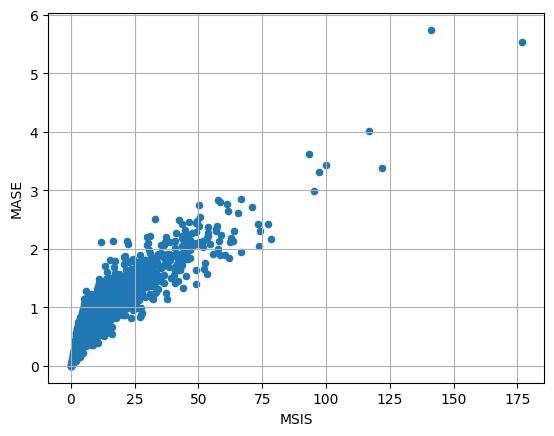

In [11]:
ts_metrics.plot(x="MSIS", y="MASE", kind="scatter")
plt.grid(which="both")
plt.show()

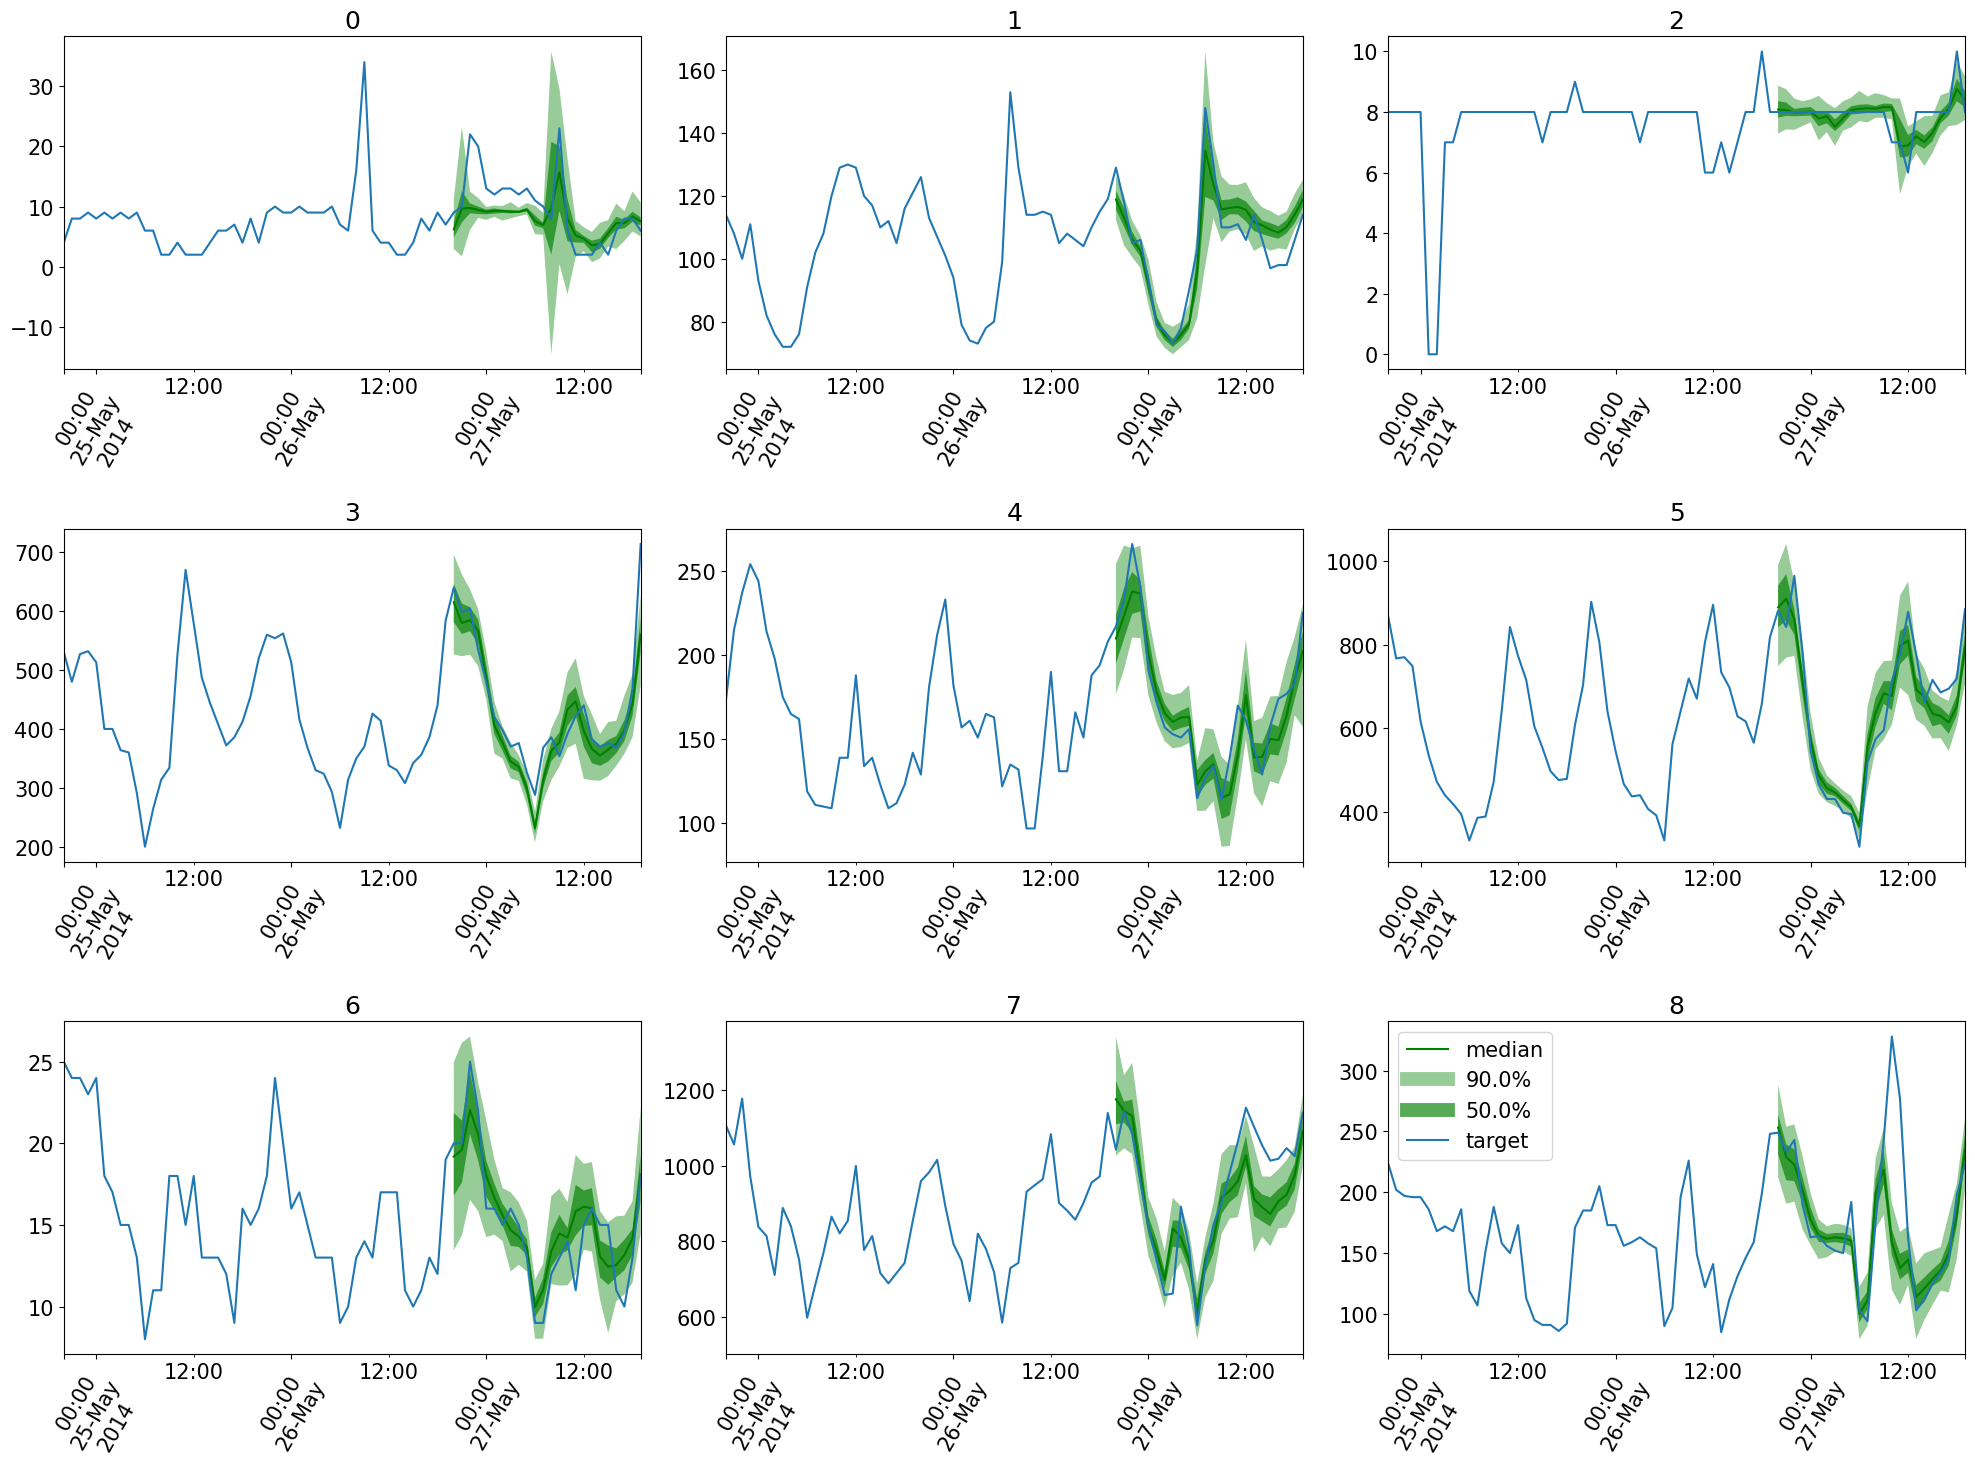

In [12]:
plt.figure(figsize=(20, 15))
plt.rcParams.update({'font.size': 15})

for idx, (forecast, ts) in islice(enumerate(zip(forecasts, tss)), 9):
    ax = plt.subplot(3, 3, idx+1)
    forecast.plot(color='g')
    ts[-3 * dataset.metadata.prediction_length:][0].plot(label="target")
    plt.xticks(rotation=60)
    ax.set_title(forecast.item_id)

plt.gcf().tight_layout()
plt.legend()
plt.show()

In [10]:
estimator = LagGPTEstimator(
    prediction_length=meta.prediction_length,
    context_length=1024, # block_size: int = 2048 
    batch_size=32, # 4
    n_layer=16,
    n_head=4,
    n_embd=64, # 4096
    scaling="std",
    num_batches_per_epoch=100,
    trainer_kwargs=dict(max_epochs=100, accelerator="gpu", precision="bf16-mixed", logger=WandbLogger()),
)

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: krasul. Use `wandb login --relogin` to force relogin


In [11]:
predictor = estimator.train(
    training_data=dataset, 
    validation_data=val_dataset,
    shuffle_buffer_length=1000
)

Authorization required, but no authorization protocol specified
Using bfloat16 Automatic Mixed Precision (AMP)
Authorization required, but no authorization protocol specified
Authorization required, but no authorization protocol specified
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type        | Params
--------------------------------------
0 | model | LagGPTModel | 1.1 M 
--------------------------------------
1.1 M     Trainable params
0         Non-trainable para

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

/mnt/scratch/kashif/pytorch-transformer-ts/lag-gpt/aug.py:31: UserWarning: The torch.cuda.*DtypeTensor constructors are no longer recommended. It's best to use methods such as torch.tensor(data, dtype=*, device='cuda') to create tensors. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:83.)
  m = torch.cuda.FloatTensor(xy_f.shape).uniform_() < rate


Validation: 0it [00:00, ?it/s]

Epoch 0, global step 100: 'val_loss' reached 7.61174 (best 7.61174), saving model to './lightning_logs/nwyllhx3/checkpoints/epoch=0-step=100.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 1, global step 200: 'val_loss' reached 7.28872 (best 7.28872), saving model to './lightning_logs/nwyllhx3/checkpoints/epoch=1-step=200.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 2, global step 300: 'val_loss' reached 7.18289 (best 7.18289), saving model to './lightning_logs/nwyllhx3/checkpoints/epoch=2-step=300.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 3, global step 400: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 4, global step 500: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 5, global step 600: 'val_loss' reached 7.12929 (best 7.12929), saving model to './lightning_logs/nwyllhx3/checkpoints/epoch=5-step=600.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 6, global step 700: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 7, global step 800: 'val_loss' reached 7.11086 (best 7.11086), saving model to './lightning_logs/nwyllhx3/checkpoints/epoch=7-step=800.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 8, global step 900: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 9, global step 1000: 'val_loss' reached 7.01333 (best 7.01333), saving model to './lightning_logs/nwyllhx3/checkpoints/epoch=9-step=1000.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 10, global step 1100: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 11, global step 1200: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 12, global step 1300: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 13, global step 1400: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 14, global step 1500: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 15, global step 1600: 'val_loss' reached 6.97959 (best 6.97959), saving model to './lightning_logs/nwyllhx3/checkpoints/epoch=15-step=1600.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 16, global step 1700: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 17, global step 1800: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 18, global step 1900: 'val_loss' reached 6.96449 (best 6.96449), saving model to './lightning_logs/nwyllhx3/checkpoints/epoch=18-step=1900.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 19, global step 2000: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 20, global step 2100: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 21, global step 2200: 'val_loss' reached 6.94370 (best 6.94370), saving model to './lightning_logs/nwyllhx3/checkpoints/epoch=21-step=2200.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 22, global step 2300: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 23, global step 2400: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 24, global step 2500: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 25, global step 2600: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 26, global step 2700: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 27, global step 2800: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 28, global step 2900: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 29, global step 3000: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 30, global step 3100: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 31, global step 3200: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 32, global step 3300: 'val_loss' reached 6.90948 (best 6.90948), saving model to './lightning_logs/nwyllhx3/checkpoints/epoch=32-step=3300.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 33, global step 3400: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 34, global step 3500: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 35, global step 3600: 'val_loss' reached 6.89655 (best 6.89655), saving model to './lightning_logs/nwyllhx3/checkpoints/epoch=35-step=3600.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 36, global step 3700: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 37, global step 3800: 'val_loss' reached 6.87883 (best 6.87883), saving model to './lightning_logs/nwyllhx3/checkpoints/epoch=37-step=3800.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 38, global step 3900: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 39, global step 4000: 'val_loss' reached 6.84392 (best 6.84392), saving model to './lightning_logs/nwyllhx3/checkpoints/epoch=39-step=4000.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 40, global step 4100: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 41, global step 4200: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 42, global step 4300: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 43, global step 4400: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 44, global step 4500: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 45, global step 4600: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 46, global step 4700: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 47, global step 4800: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 48, global step 4900: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 49, global step 5000: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 50, global step 5100: 'val_loss' reached 6.84029 (best 6.84029), saving model to './lightning_logs/nwyllhx3/checkpoints/epoch=50-step=5100.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 51, global step 5200: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 52, global step 5300: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 53, global step 5400: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 54, global step 5500: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 55, global step 5600: 'val_loss' reached 6.83912 (best 6.83912), saving model to './lightning_logs/nwyllhx3/checkpoints/epoch=55-step=5600.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 56, global step 5700: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 57, global step 5800: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 58, global step 5900: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 59, global step 6000: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 60, global step 6100: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 61, global step 6200: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 62, global step 6300: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 63, global step 6400: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 64, global step 6500: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 65, global step 6600: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 66, global step 6700: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 67, global step 6800: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 68, global step 6900: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 69, global step 7000: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 70, global step 7100: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 71, global step 7200: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 72, global step 7300: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 73, global step 7400: 'val_loss' reached 6.79561 (best 6.79561), saving model to './lightning_logs/nwyllhx3/checkpoints/epoch=73-step=7400.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 74, global step 7500: 'val_loss' reached 6.79088 (best 6.79088), saving model to './lightning_logs/nwyllhx3/checkpoints/epoch=74-step=7500.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 75, global step 7600: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 76, global step 7700: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 77, global step 7800: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 78, global step 7900: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 79, global step 8000: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 80, global step 8100: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 81, global step 8200: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 82, global step 8300: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 83, global step 8400: 'val_loss' reached 6.76567 (best 6.76567), saving model to './lightning_logs/nwyllhx3/checkpoints/epoch=83-step=8400.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 84, global step 8500: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 85, global step 8600: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 86, global step 8700: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 87, global step 8800: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 88, global step 8900: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 89, global step 9000: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 90, global step 9100: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 91, global step 9200: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 92, global step 9300: 'val_loss' reached 6.75034 (best 6.75034), saving model to './lightning_logs/nwyllhx3/checkpoints/epoch=92-step=9300.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 93, global step 9400: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 94, global step 9500: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 95, global step 9600: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 96, global step 9700: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 97, global step 9800: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 98, global step 9900: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 99, global step 10000: 'val_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=100` reached.


In [11]:
estimator = LagGPTEstimator(
    prediction_length=meta.prediction_length,
    context_length=1024, # block_size: int = 2048 
    batch_size=32, # 4
    n_layer=16,
    n_head=4,
    n_embd=64, # 4096
    scaling="std",
    num_batches_per_epoch=100,
    trainer_kwargs=dict(max_epochs=100, accelerator="gpu", precision="bf16-mixed", logger=WandbLogger()),
)

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: krasul. Use `wandb login --relogin` to force relogin


In [12]:
predictor = estimator.train(
    training_data=dataset, 
    validation_data=val_dataset,
    shuffle_buffer_length=1000
)

Authorization required, but no authorization protocol specified
Using bfloat16 Automatic Mixed Precision (AMP)
Authorization required, but no authorization protocol specified
Authorization required, but no authorization protocol specified
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type        | Params
--------------------------------------
0 | model | LagGPTModel | 1.1 M 
--------------------------------------
1.1 M     Trainable params
0         Non-trainable para

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

/mnt/scratch/kashif/pytorch-transformer-ts/lag-gpt/aug.py:11: UserWarning: The torch.cuda.*DtypeTensor constructors are no longer recommended. It's best to use methods such as torch.tensor(data, dtype=*, device='cuda') to create tensors. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:83.)
  m = torch.cuda.FloatTensor(xy_f.shape).uniform_() < rate


Validation: 0it [00:00, ?it/s]

Epoch 0, global step 100: 'val_loss' reached 7.51235 (best 7.51235), saving model to './lightning_logs/oh8xlr6f/checkpoints/epoch=0-step=100.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 1, global step 200: 'val_loss' reached 7.31993 (best 7.31993), saving model to './lightning_logs/oh8xlr6f/checkpoints/epoch=1-step=200.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 2, global step 300: 'val_loss' reached 7.21307 (best 7.21307), saving model to './lightning_logs/oh8xlr6f/checkpoints/epoch=2-step=300.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 3, global step 400: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 4, global step 500: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 5, global step 600: 'val_loss' reached 7.16927 (best 7.16927), saving model to './lightning_logs/oh8xlr6f/checkpoints/epoch=5-step=600.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 6, global step 700: 'val_loss' reached 7.10690 (best 7.10690), saving model to './lightning_logs/oh8xlr6f/checkpoints/epoch=6-step=700.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 7, global step 800: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 8, global step 900: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 9, global step 1000: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 10, global step 1100: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 11, global step 1200: 'val_loss' reached 7.10592 (best 7.10592), saving model to './lightning_logs/oh8xlr6f/checkpoints/epoch=11-step=1200.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 12, global step 1300: 'val_loss' reached 7.05876 (best 7.05876), saving model to './lightning_logs/oh8xlr6f/checkpoints/epoch=12-step=1300.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 13, global step 1400: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 14, global step 1500: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 15, global step 1600: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 16, global step 1700: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 17, global step 1800: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 18, global step 1900: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 19, global step 2000: 'val_loss' reached 7.00779 (best 7.00779), saving model to './lightning_logs/oh8xlr6f/checkpoints/epoch=19-step=2000.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 20, global step 2100: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 21, global step 2200: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 22, global step 2300: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 23, global step 2400: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 24, global step 2500: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 25, global step 2600: 'val_loss' reached 6.98783 (best 6.98783), saving model to './lightning_logs/oh8xlr6f/checkpoints/epoch=25-step=2600.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 26, global step 2700: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 27, global step 2800: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 28, global step 2900: 'val_loss' reached 6.93505 (best 6.93505), saving model to './lightning_logs/oh8xlr6f/checkpoints/epoch=28-step=2900.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 29, global step 3000: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 30, global step 3100: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 31, global step 3200: 'val_loss' reached 6.89744 (best 6.89744), saving model to './lightning_logs/oh8xlr6f/checkpoints/epoch=31-step=3200.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 32, global step 3300: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 33, global step 3400: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 34, global step 3500: 'val_loss' reached 6.87373 (best 6.87373), saving model to './lightning_logs/oh8xlr6f/checkpoints/epoch=34-step=3500.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 35, global step 3600: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 36, global step 3700: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 37, global step 3800: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 38, global step 3900: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 39, global step 4000: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 40, global step 4100: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 41, global step 4200: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 42, global step 4300: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 43, global step 4400: 'val_loss' reached 6.86213 (best 6.86213), saving model to './lightning_logs/oh8xlr6f/checkpoints/epoch=43-step=4400.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 44, global step 4500: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 45, global step 4600: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 46, global step 4700: 'val_loss' reached 6.84430 (best 6.84430), saving model to './lightning_logs/oh8xlr6f/checkpoints/epoch=46-step=4700.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 47, global step 4800: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 48, global step 4900: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 49, global step 5000: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 50, global step 5100: 'val_loss' reached 6.78814 (best 6.78814), saving model to './lightning_logs/oh8xlr6f/checkpoints/epoch=50-step=5100.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 51, global step 5200: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 52, global step 5300: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 53, global step 5400: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 54, global step 5500: 'val_loss' reached 6.78248 (best 6.78248), saving model to './lightning_logs/oh8xlr6f/checkpoints/epoch=54-step=5500.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 55, global step 5600: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 56, global step 5700: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 57, global step 5800: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 58, global step 5900: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 59, global step 6000: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 60, global step 6100: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 61, global step 6200: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 62, global step 6300: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 63, global step 6400: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 64, global step 6500: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 65, global step 6600: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 66, global step 6700: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 67, global step 6800: 'val_loss' reached 6.75252 (best 6.75252), saving model to './lightning_logs/oh8xlr6f/checkpoints/epoch=67-step=6800.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 68, global step 6900: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 69, global step 7000: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 70, global step 7100: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 71, global step 7200: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 72, global step 7300: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 73, global step 7400: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 74, global step 7500: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 75, global step 7600: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 76, global step 7700: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 77, global step 7800: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 78, global step 7900: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 79, global step 8000: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 80, global step 8100: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 81, global step 8200: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 82, global step 8300: 'val_loss' reached 6.73121 (best 6.73121), saving model to './lightning_logs/oh8xlr6f/checkpoints/epoch=82-step=8300.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 83, global step 8400: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 84, global step 8500: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 85, global step 8600: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 86, global step 8700: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 87, global step 8800: 'val_loss' reached 6.71938 (best 6.71938), saving model to './lightning_logs/oh8xlr6f/checkpoints/epoch=87-step=8800.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 88, global step 8900: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 89, global step 9000: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 90, global step 9100: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 91, global step 9200: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 92, global step 9300: 'val_loss' reached 6.70150 (best 6.70150), saving model to './lightning_logs/oh8xlr6f/checkpoints/epoch=92-step=9300.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 93, global step 9400: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 94, global step 9500: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 95, global step 9600: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 96, global step 9700: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 97, global step 9800: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 98, global step 9900: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 99, global step 10000: 'val_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=100` reached.
